# Матчинг товаров

Цель: на основе датасетов, обучающей и тренировочной выборки с помощью FAISS подготовить по 5 "похожих" товаров и оценить их по методу `accuracy@5`.

## Загружаем данные

In [30]:
import pandas as pd
import numpy as np 
import faiss
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler

import warnings
warnings.filterwarnings("ignore")

In [31]:
RANDOM_STATE = 12345
np.random.seed(RANDOM_STATE)

In [32]:
# Файл со всеми товарами
df_base = pd.read_csv('data/base.csv', index_col='Id')

# Тренировочный датасет
df_train = pd.read_csv('data/train.csv', index_col='Id')

# Выборка для валидации
df_validation = pd.read_csv('data/validation.csv', index_col='Id')
df_validation_answers = pd.read_csv('data/validation_answer.csv', index_col='Id')

## Анализируем данные

Признаки представляют из себя вектора чисел с плавающей точкой. Контекст и назначение признаков неизвестны:

In [33]:
df_base.head(5)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


Профайлер не работает, поэтому просто посмотрим гистограммы.

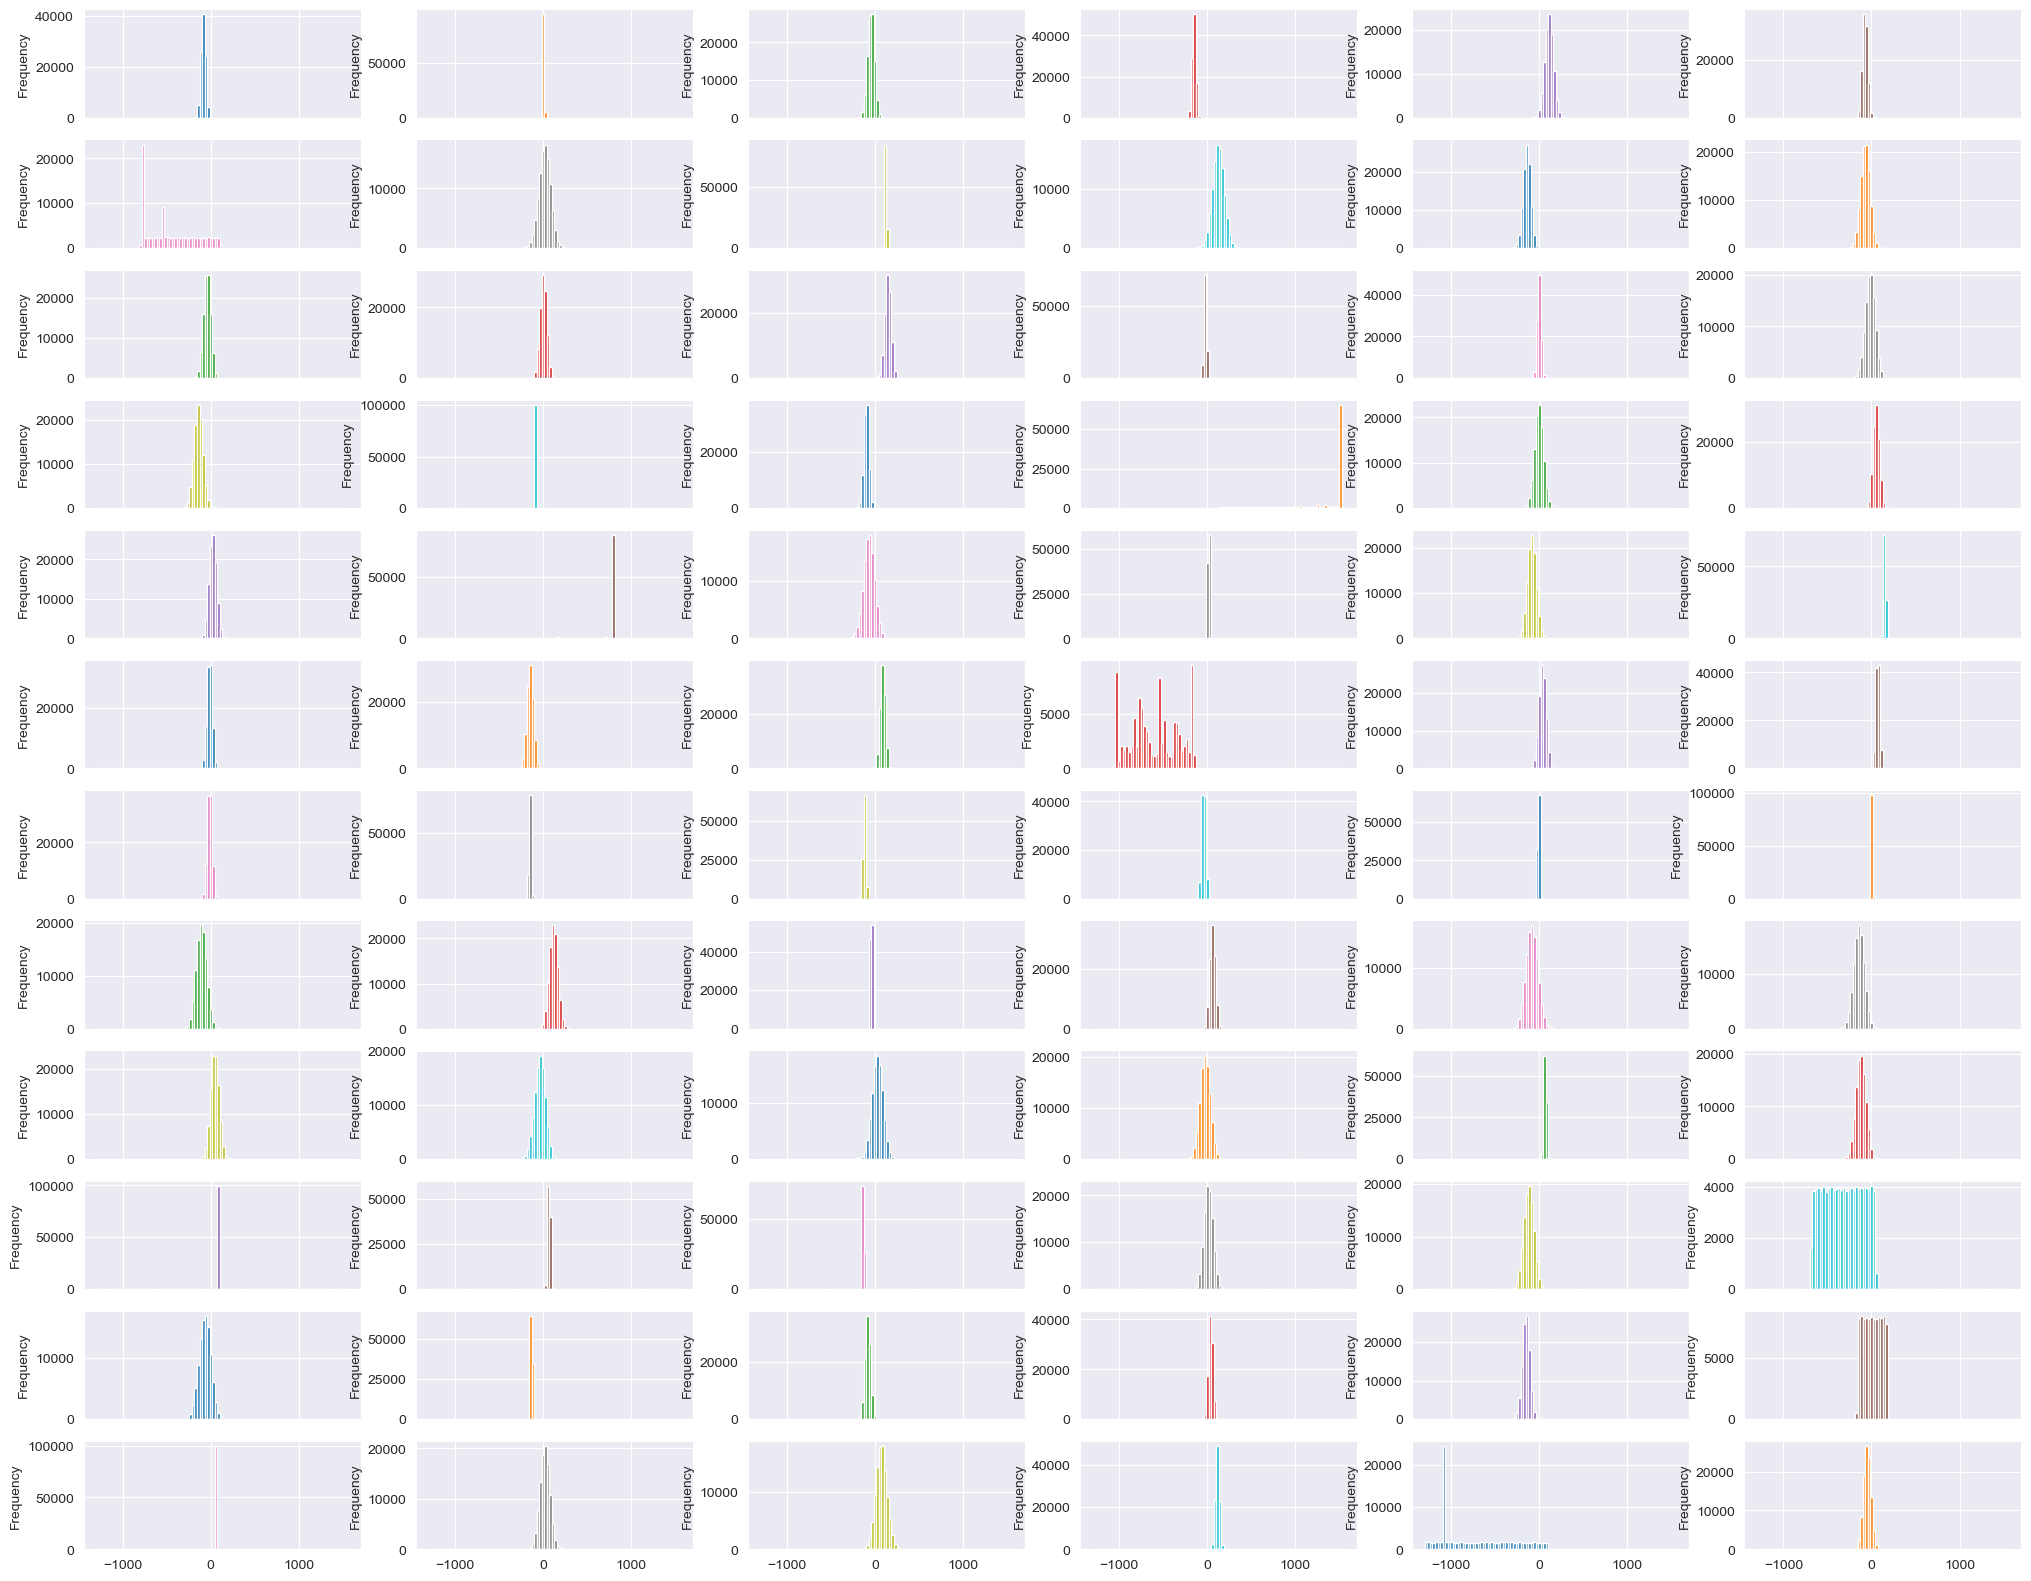

In [34]:
df_train.plot(subplots=True, layout=(12,6), kind='hist', figsize=(25,20), bins=100, legend=False)
plt.show()

Посмотрим корреляцию признаков. Видно, что где-то встречается обратная корреляция, но сильной прямой корреляции нет:

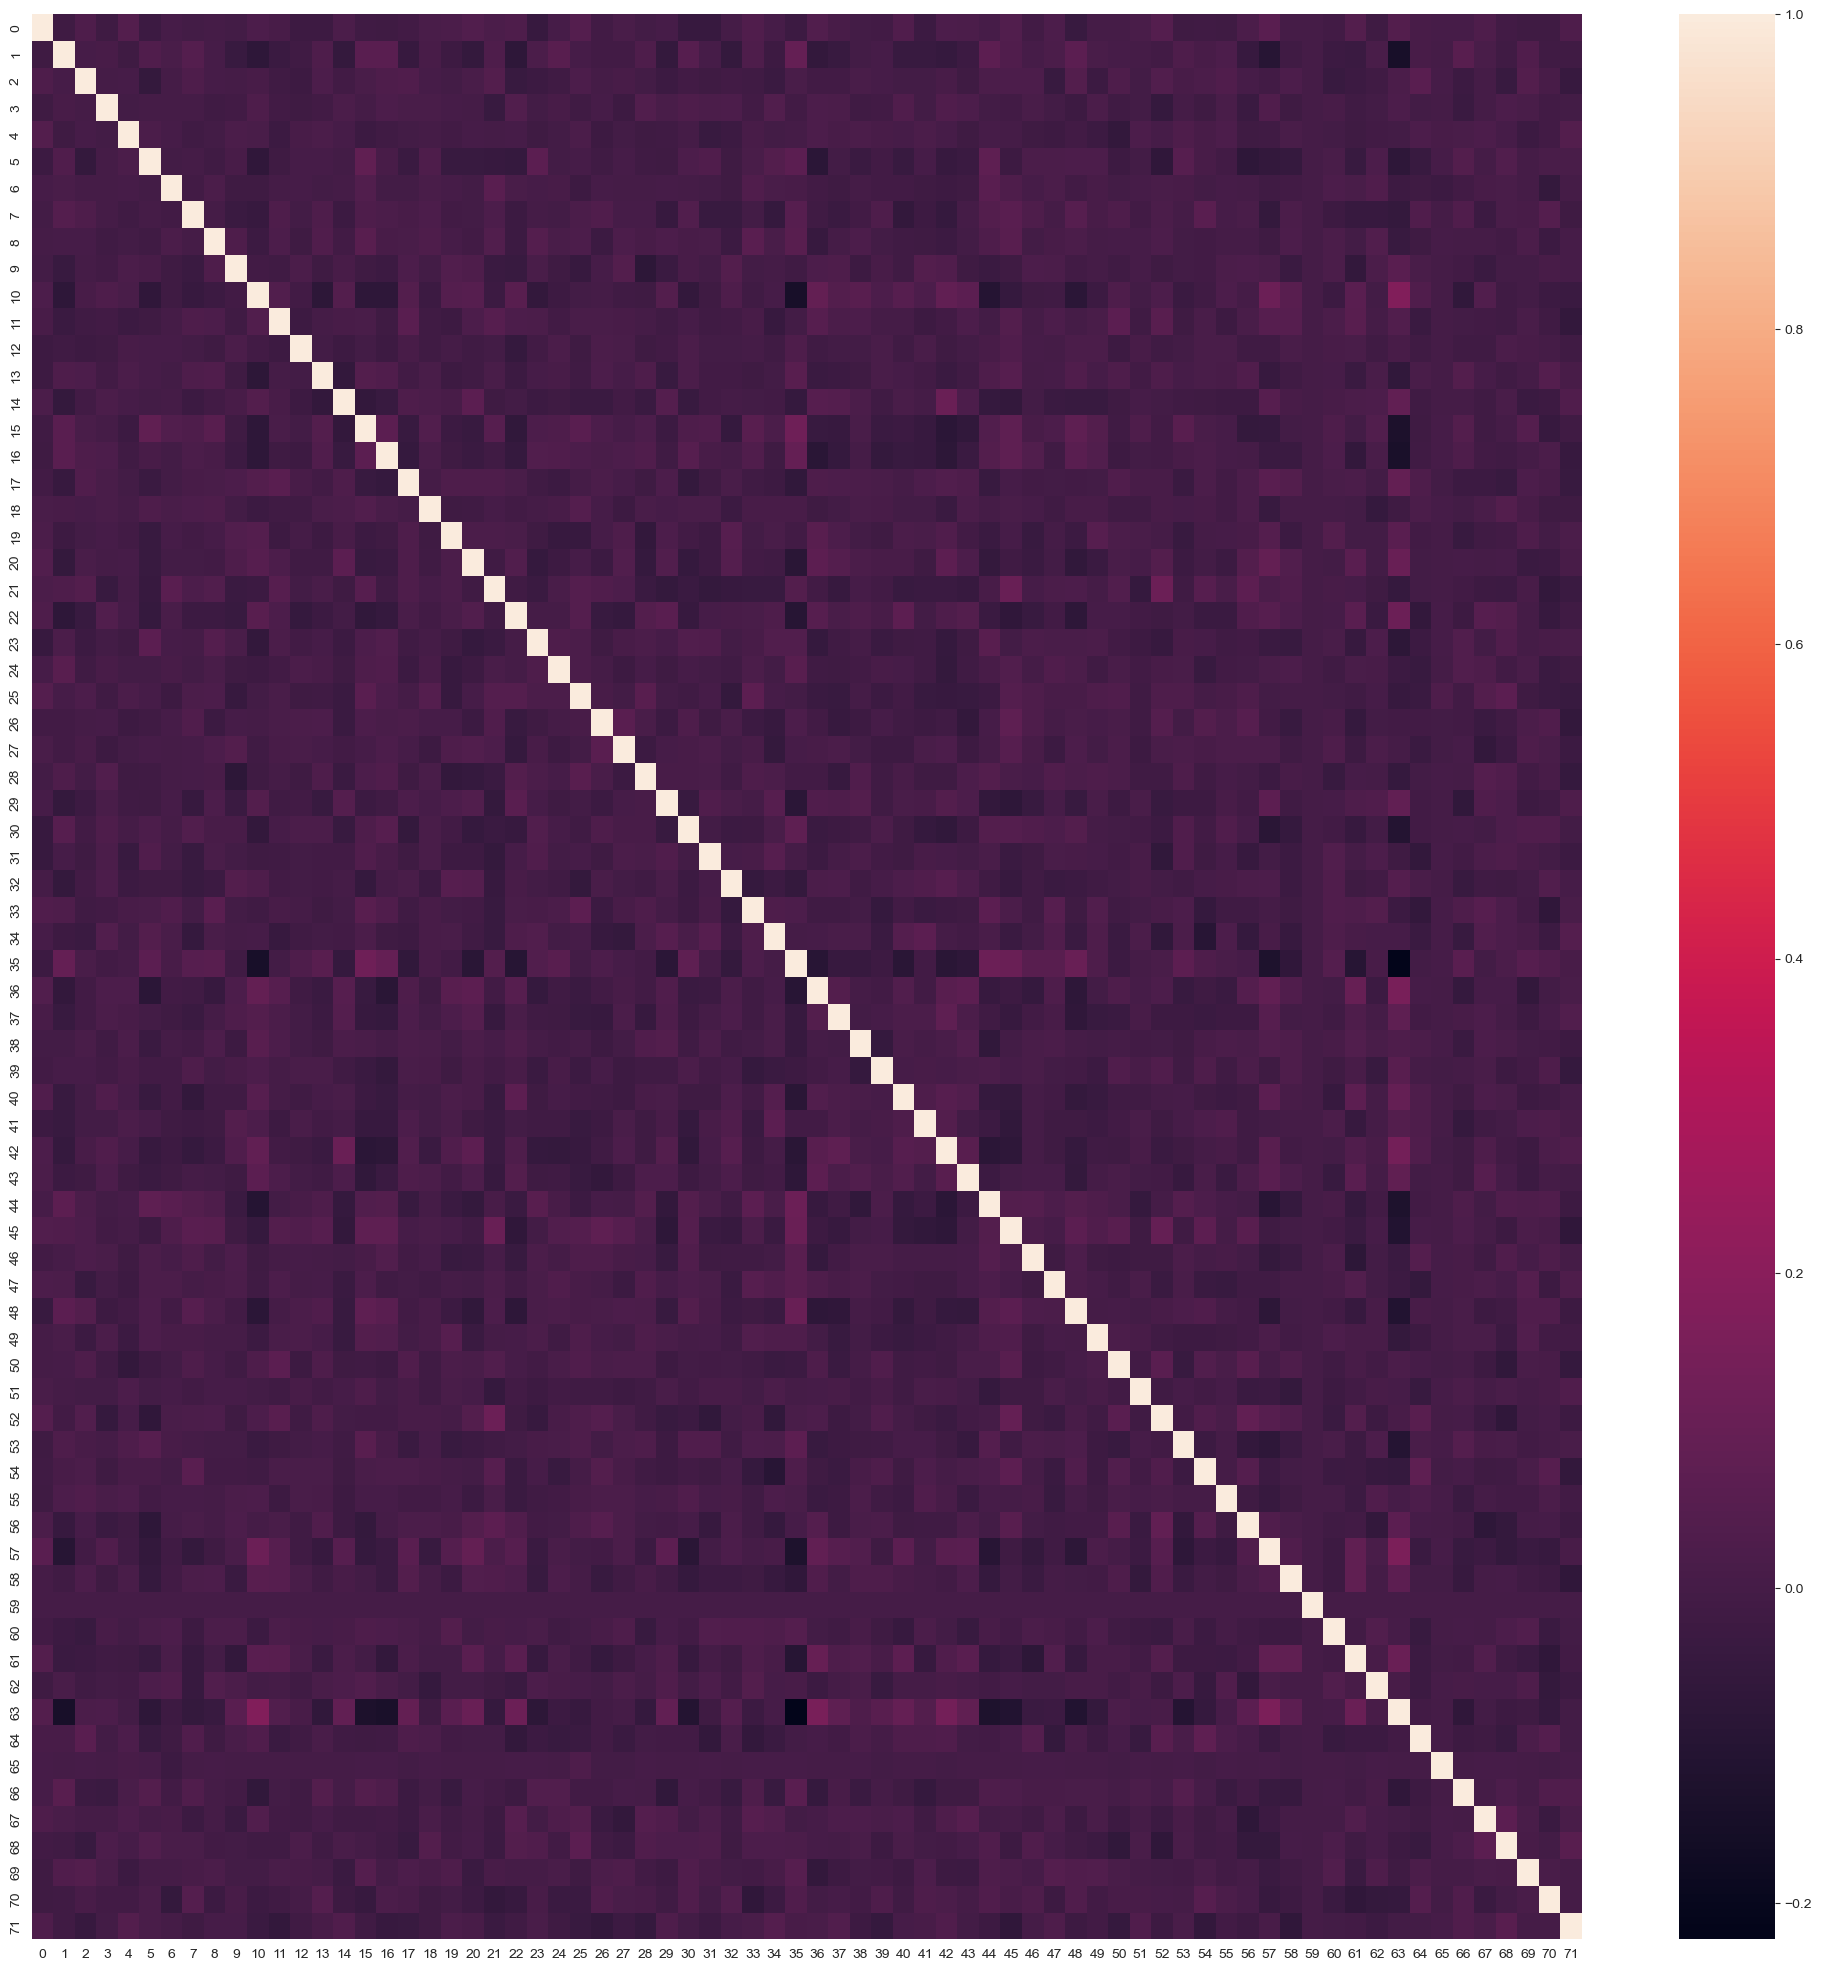

In [35]:
fig, ax = plt.subplots(figsize=(25,25))
sns.heatmap(df_base.corr(), ax=ax);

Убедимся, что все таргеты в тренировочной и валидационной выборках есть в базовой выборке:

In [36]:
df_validation_answers.merge(df_base, how='inner', left_on='Expected', right_index=True).shape[0] == df_validation_answers.shape[0]

True

In [37]:
df_train[['Target']].merge(df_base, how='inner', left_on='Target', right_index=True).shape[0] == df_train.shape[0]

True

## Делаем прогноз

Функция для оценки результатов:

In [38]:
def accuracy_5(targets, predictions):
    success = 0
    for target, el in zip(targets.values.tolist(), predictions.tolist()):
        success += int(target in [base_index[r] for r in el])
    return 100 * success / len(predictions)

Заранее готовим словарь для конверсии индекса в идентификатор товара:

In [39]:
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

Готовим тренировочную выборку:

In [40]:
y_train = df_train["Target"]
X_train = df_train.drop("Target", axis=1)

Готовим валидационную выборку:

In [41]:
y_validation = df_validation_answers['Expected']
X_validation = df_validation

Стандартизуем с помощью `RobustScaler`:

In [42]:
transformer = RobustScaler().fit(df_base.values)
df_base_transformed = pd.DataFrame(index=df_base.index, data=transformer.transform(df_base.values))
X_train_transformed = pd.DataFrame(index=X_train.index, data=transformer.transform(X_train.values))
X_validation_transformed = pd.DataFrame(index=X_validation.index, data=transformer.transform(X_validation.values))

Методом проб и ошибок я выяснил, что часть колонок снижают аккуратность предсказаний (аргументация в следуюшем разделе). Причем не только те, у которых не нормальное распределение, но и с нормальным распределнием. Например признак `2`. Формируем список колонок, которые будем использовать для обучения:

In [43]:
columns = [int(i) for i in range(0,72)]
columns.remove(2)
columns.remove(21)
columns.remove(25)
columns.remove(33)
columns.remove(40)
columns.remove(42)
columns.remove(52)
columns.remove(54)
columns.remove(59)
columns.remove(60)
columns.remove(61)
columns.remove(65)
columns.remove(66)

Строим модель и обучаем на тренировочных данных:

In [44]:
dims = df_base_transformed[columns].shape[1]
n_cells = 1
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells, faiss.METRIC_L2)
idx_l2.train(np.ascontiguousarray(df_base_transformed[columns]).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base_transformed[columns]).astype('float32'))
r, idx = idx_l2.search(np.ascontiguousarray(X_train_transformed[columns]).astype('float32'), 5)
print("Аккуратность предсказаний на тренировочной выборке:", accuracy_5(y_train, idx), "%")

Аккуратность предсказаний на тренировочной выборке: 71.644 %


Проверяем модель на валидационной выборке:

In [45]:
r, idx = idx_l2.search(np.ascontiguousarray(X_validation_transformed[columns]).astype('float32'), 5)
print("Аккуратность предсказаний на валидационной выборке:", accuracy_5(y_validation, idx), "%")

Аккуратность предсказаний на валидационной выборке: 71.384 %


Сохраняем индекс для веб-сервиса:

In [46]:
faiss.write_index(idx_l2, './model.index')

# Выводы

Так как у нас анонимизированные признаки, да еще и закодированные, мы не знаем, какой признак важен, а какой нет.

Похожесть товаров в сервисах товарных рекомендаций делается довольно просто. Для этого не требуется 72 признака. Главный признак, который влияет на схожесть товаров: категория товара. Два товара из двух разных категорий не могут быть схожи. Поэтому должно быть точное совпадение категории.

Затем уже сверяются остальные признаки, такие как характеристики или цена. Но характеристики тоже зависят от категории. Ширина в разделе "Смартфоны" не то же самое, что ширина в разделе "Шкафы". При этом мы не знаем, как в нашем датасете закодирована ширина: она отмасштабирована по всему датасету или в рамках каждой категории (между минимумом и максимумом).

Нюансов и проблем много. Поэтому перебор гиперпараметров и вариантов моделей не является лучшим способом для разработки подходящей модели. Для начала нужно исключить "вредные" признаки. Те, которые никак не связаны с похожестью товаров. Я это сделал, просто по очереди удаляя колонки и проверяя, растет ли метрика или падает. Если падает, то колонка возвращается обратно.

Таким образом удалось найти 14 признаков, негативно влияющих на аккуратность предсказаний. Причем явных визуальных критериев для удаления нет. Например признак №1 не имеет нормального распределения, но его удаление ведет к сильному снижению точности. А признак 2 распределен нормально, но его наличие снижает точность.

В условиях ограничения по времени, как MVP это решение работоспособно. В дальнейшем можно уже оптимизировать гиперпараметры и пробовать другие виды моделей для улучшения качества. 
